# Predict bank customers churn

In [1]:
%matplotlib inline
import psycopg2
import pickle

# data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Explainability
import shap

c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

the dataset is available here: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

- CustomerId—contains random values and has no effect on customer leaving the bank.
- Surname—the surname of a customer has no impact on their decision to leave the bank.
- CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- Geography—a customer’s location can affect their decision to leave the bank.
- Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
-Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- NumOfProducts—refers to the number of products that a customer has purchased through the bank.
- HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- IsActiveMember—active customers are less likely to leave the bank.
- EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- Churn—whether or not the customer left the bank.

In [2]:
## load data from local csv 
#df = pd.read_csv(
#        filepath_or_buffer = '../data/bank_customers_churn_dataset.csv',
#        index_col='customer_id'
#)
#
## drop churn column for segmentation
#df.drop('churn', axis=1, inplace=True)
#
## change type of categorical columns "credit_card" and "active_member"
#df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
#df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')
#
#df.head()

In [3]:
def get_data_from_my_postgre_db(password:str, table_name:str)->pd.DataFrame:
    """connects to marketing_analytics db and returns data from table_name as pandas dataframe .
    inputs: database password and table_name"""
    # Connect to the database
    conn = psycopg2.connect(
        database="marketing_analytics", 
        user="postgres", 
        password=password, 
        host="localhost", 
        port="5432")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a SQL query
    #cur.execute("SELECT * FROM bank_customers_churn_dataset")
    cur.execute("SELECT * FROM " + table_name) 
    # Get the column names from the cursor description
    columns = [desc[0] for desc in cur.description]
    # Fetch the results i.e. values
    results = cur.fetchall()
    # Create a dictionary mapping column names to values
    data = [dict(zip(columns, row)) for row in results]
    # Close the connection
    conn.close()
    # turn dictionary into dataframe
    return pd.DataFrame.from_dict(data)

In [4]:
f = open("../private.txt", "r")
pw = f.read()

In [5]:
# get data from postres db
table_name = "bank_customers_churn_dataset"
df = get_data_from_my_postgre_db(pw, table_name)

# set customer id as index
df.set_index('customer_id', inplace=True)

## change churn column type to bool
df['churn'] = df['churn'].astype('int').astype('bool')

# change data types to numeric
df['tenure'] = df['tenure'].apply(lambda x: int(x))
df['products_number'] = df['products_number'].apply(lambda x: int(x))
df['credit_card'] = df['credit_card'].apply(lambda x: int(x))
df['active_member'] = df['active_member'].apply(lambda x: int(x))

# change type of categorical columns "credit_card" and "active_member"
df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

In [6]:
df.dtypes

credit_score        float64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card          object
active_member        object
estimated_salary    float64
churn                  bool
dtype: object

In [7]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619.0,France,Female,42,2,0.00,1,yes,yes,101348.88,True
15647311,608.0,Spain,Female,41,1,83807.86,1,no,yes,112542.58,False
15619304,502.0,France,Female,42,8,159660.80,3,yes,no,113931.57,True
15701354,699.0,France,Female,39,1,0.00,2,no,no,93826.63,False
15737888,850.0,Spain,Female,43,2,125510.82,1,yes,yes,79084.10,False


In [8]:
# check unique values for categorical values
print(df['country'].unique())
print(df['gender'].unique())
print(df['credit_card'].unique())
print(df['active_member'].unique())
print(df['churn'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']
['yes' 'no']
['yes' 'no']
[ True False]


# Train-Test Split the Data

In [9]:
df.shape

(10000, 11)

In [10]:
# divide features and target
X = df.iloc[:,:-1]
y = df['churn'].values

In [11]:
# way too much data for training; let´s split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5, 
    stratify=y,
    random_state=123)

In [12]:
X_train.shape

(5000, 10)

In [13]:
X_test.shape

(5000, 10)

In [14]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15733705,577.0,France,Female,30,8,92472.10,2,no,yes,126434.61
15580719,697.0,France,Female,23,10,0.00,2,yes,yes,79734.23
15613923,581.0,Spain,Female,43,4,170172.90,1,no,yes,100236.02
15624703,550.0,Germany,Male,35,9,129847.75,2,yes,no,197325.40
15743817,621.0,Germany,Male,40,8,174126.75,3,yes,no,172490.78


# Exploratory Data Analysis

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 15733705 to 15696852
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      5000 non-null   float64
 1   country           5000 non-null   object 
 2   gender            5000 non-null   object 
 3   age               5000 non-null   int64  
 4   tenure            5000 non-null   int64  
 5   balance           5000 non-null   float64
 6   products_number   5000 non-null   int64  
 7   credit_card       5000 non-null   object 
 8   active_member     5000 non-null   object 
 9   estimated_salary  5000 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 429.7+ KB


In [16]:
X_train.isna().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
dtype: int64

## Impute Missing Values

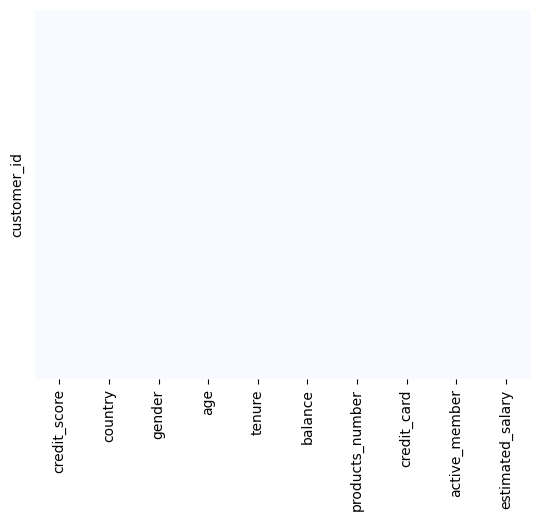

In [17]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [18]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [19]:
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
numeric_columns

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'estimated_salary']

In [20]:
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()
categorical_columns

['country', 'gender', 'credit_card', 'active_member']

In [21]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,credit_score,age,tenure,balance,products_number,estimated_salary
customer_id,,,,,,
15733705,577.0,30.0,8.0,92472.10,2.0,126434.61
15580719,697.0,23.0,10.0,0.00,2.0,79734.23
15613923,581.0,43.0,4.0,170172.90,1.0,100236.02
15624703,550.0,35.0,9.0,129847.75,2.0,197325.40
15743817,621.0,40.0,8.0,174126.75,3.0,172490.78


In [22]:
# impute missing numeric values in test dataset
X_test_numeric = numeric_imputer.transform(X_test.select_dtypes(include=numerics))
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_columns, index=X_test.index)
X_test_numeric.head()

,credit_score,age,tenure,balance,products_number,estimated_salary
customer_id,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.93
15736397,544.0,23.0,1.0,96471.20,1.0,35550.97
15596405,546.0,25.0,7.0,127728.24,2.0,105279.74
15623595,586.0,28.0,2.0,0.00,2.0,92067.35
15605684,664.0,31.0,7.0,104158.84,1.0,134169.85


In [23]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,country,gender,credit_card,active_member
customer_id,,,,
15733705,France,Female,no,yes
15580719,France,Female,yes,yes
15613923,Spain,Female,no,yes
15624703,Germany,Male,yes,no
15743817,Germany,Male,yes,no


In [24]:
# Impute missing categorical values in test dataset
X_test_categorical = categorical_imputer.transform(X_test.select_dtypes(exclude=numerics))
X_test_categorical = pd.DataFrame(X_test_categorical, columns=categorical_columns, index=X_test.index)
X_test_categorical.head()

,country,gender,credit_card,active_member
customer_id,,,,
15704651,France,Male,no,no
15736397,France,Male,yes,no
15596405,Spain,Male,yes,yes
15623595,Spain,Female,yes,yes
15605684,France,Female,yes,no


In [25]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [26]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15733705,577.0,30.0,8.0,92472.10,2.0,126434.61,France,Female,no,yes
15580719,697.0,23.0,10.0,0.00,2.0,79734.23,France,Female,yes,yes
15613923,581.0,43.0,4.0,170172.90,1.0,100236.02,Spain,Female,no,yes
15624703,550.0,35.0,9.0,129847.75,2.0,197325.40,Germany,Male,yes,no
15743817,621.0,40.0,8.0,174126.75,3.0,172490.78,Germany,Male,yes,no


In [27]:
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.93,France,Male,no,no
15736397,544.0,23.0,1.0,96471.20,1.0,35550.97,France,Male,yes,no
15596405,546.0,25.0,7.0,127728.24,2.0,105279.74,Spain,Male,yes,yes
15623595,586.0,28.0,2.0,0.00,2.0,92067.35,Spain,Female,yes,yes
15605684,664.0,31.0,7.0,104158.84,1.0,134169.85,France,Female,yes,no


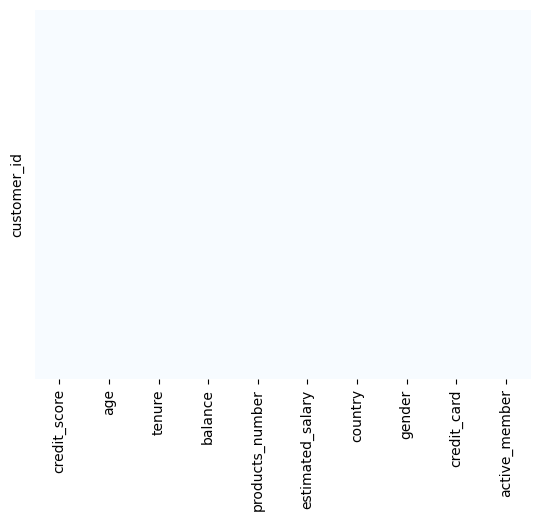

In [28]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_test.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Categorical Features

In [29]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category country: 
France     2518
Germany    1249
Spain      1233
Name: country, dtype: int64
Value counts in category gender: 
Male      2736
Female    2264
Name: gender, dtype: int64
Value counts in category credit_card: 
yes    3509
no     1491
Name: credit_card, dtype: int64
Value counts in category active_member: 
yes    2591
no     2409
Name: active_member, dtype: int64


## Encode Rare Labels

In [30]:
# encode rare labels in train data
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=10)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable country is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable credit_card is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable active_member is less than that indicated in n_categories. Thus, all categories will be considered frequent


,country,gender,credit_card,active_member
customer_id,,,,
15733705,France,Female,no,yes
15580719,France,Female,yes,yes
15613923,Spain,Female,no,yes
15624703,Germany,Male,yes,no
15743817,Germany,Male,yes,no


In [31]:
# encode rare labels in test data
X_test[categorical_columns] = rare_encoder.transform(X_test[categorical_columns])
X_test[categorical_columns].head()

,country,gender,credit_card,active_member
customer_id,,,,
15704651,France,Male,no,no
15736397,France,Male,yes,no
15596405,Spain,Male,yes,yes
15623595,Spain,Female,yes,yes
15605684,France,Female,yes,no


In [32]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Visualize Numerical Features

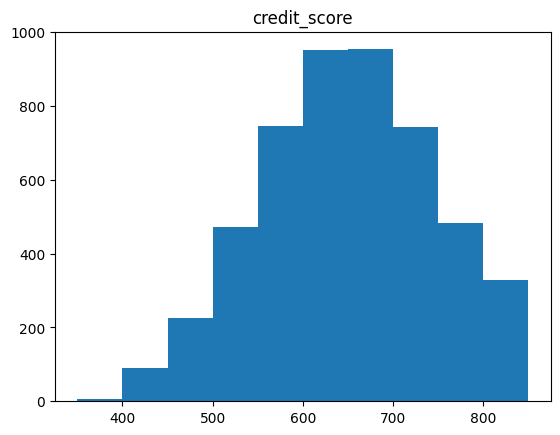

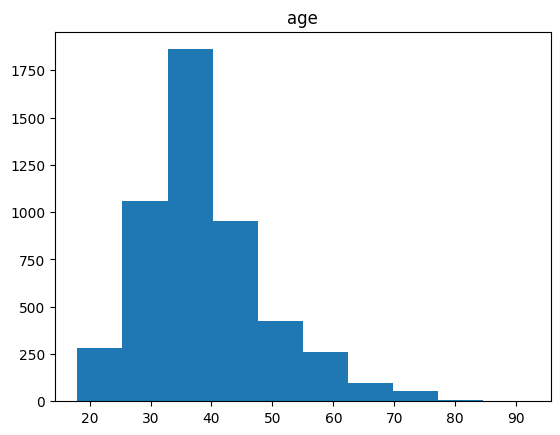

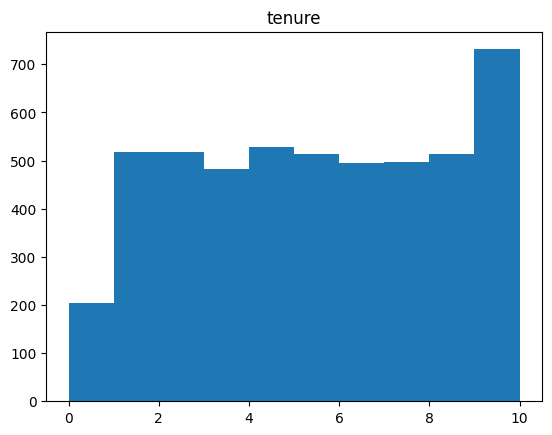

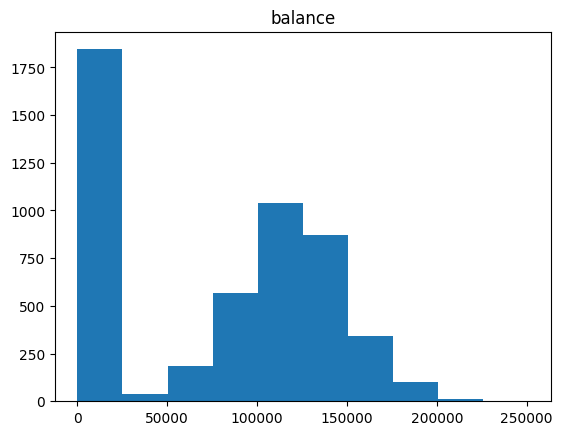

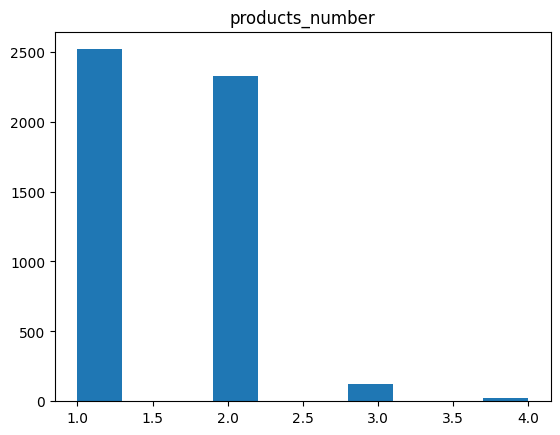

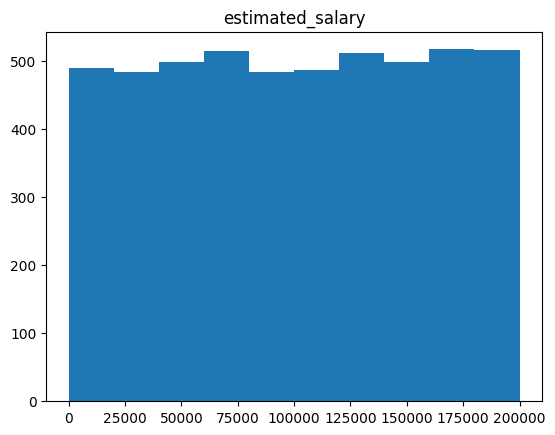

In [33]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [34]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [35]:
# fit the capper on train data
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15733705,577.0,30.0,8.0,92472.10,2.0,126434.61,France,Female,no,yes
15580719,697.0,23.0,10.0,0.00,2.0,79734.23,France,Female,yes,yes
15613923,581.0,43.0,4.0,170172.90,1.0,100236.02,Spain,Female,no,yes
15624703,550.0,35.0,9.0,129847.75,2.0,197325.40,Germany,Male,yes,no
15743817,621.0,40.0,8.0,174126.75,3.0,172490.78,Germany,Male,yes,no


In [36]:
# fit the capper on test data
X_test[numeric_columns] = capper.transform(X_test[numeric_columns])
X_test.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.93,France,Male,no,no
15736397,544.0,23.0,1.0,96471.20,1.0,35550.97,France,Male,yes,no
15596405,546.0,25.0,7.0,127728.24,2.0,105279.74,Spain,Male,yes,yes
15623595,586.0,28.0,2.0,0.00,2.0,92067.35,Spain,Female,yes,yes
15605684,664.0,31.0,7.0,104158.84,1.0,134169.85,France,Female,yes,no


In [37]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

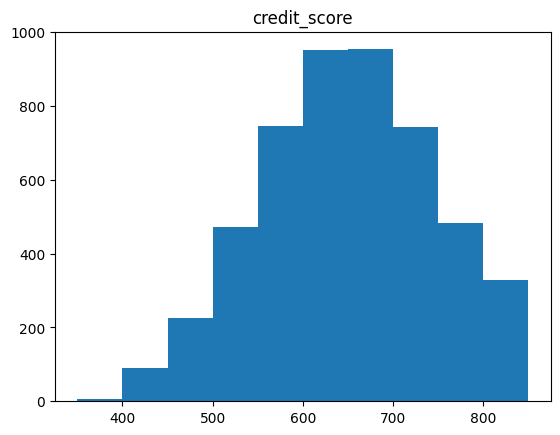

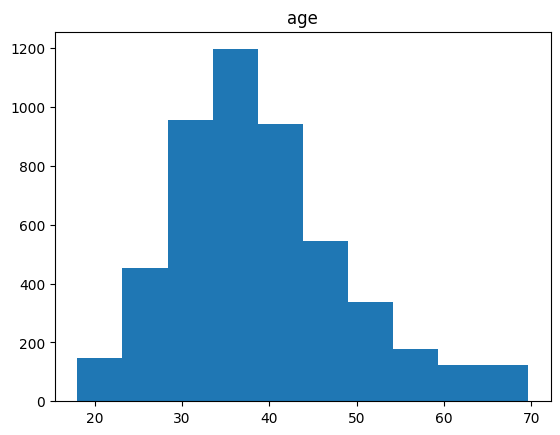

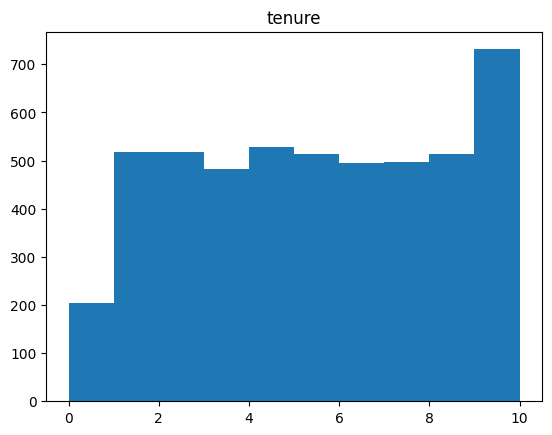

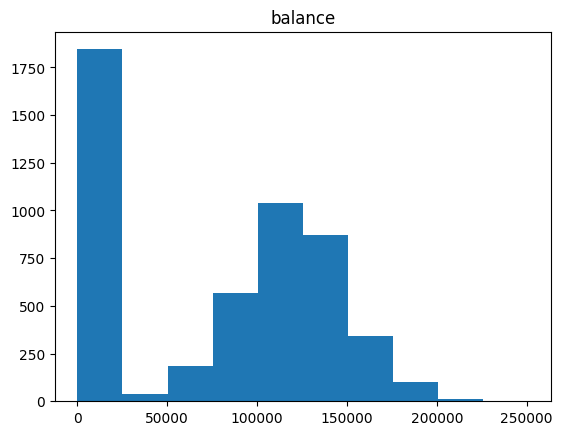

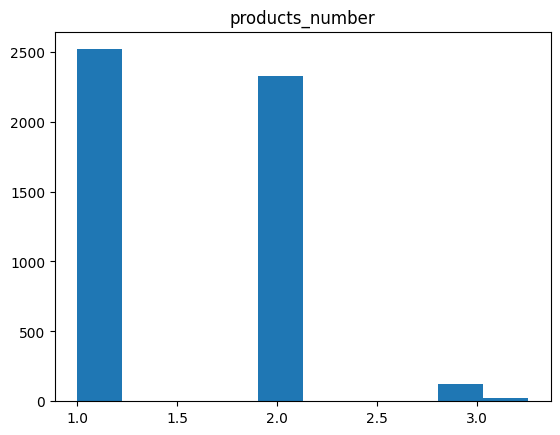

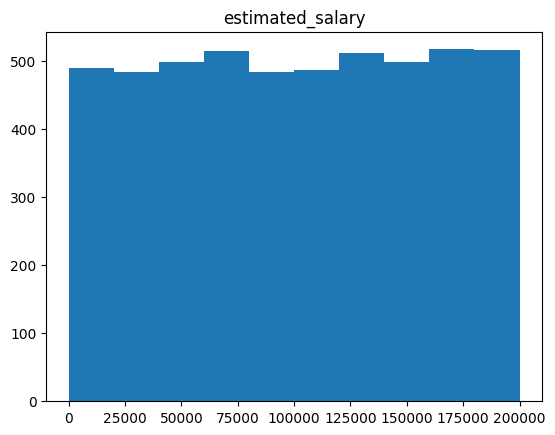

In [38]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## One-Hote Encoding

In [39]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [40]:
# hotencode train data
X_train_hot_enc = enc.fit_transform(X_train[categorical_columns])
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc.head()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,credit_score,age,tenure,balance,products_number,estimated_salary,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,,,,,,,
15733705,577.0,30.0,8.0,92472.10,2.0,126434.61,0.0,0.0,0.0,0.0,1.0
15580719,697.0,23.0,10.0,0.00,2.0,79734.23,0.0,0.0,0.0,1.0,1.0
15613923,581.0,43.0,4.0,170172.90,1.0,100236.02,0.0,1.0,0.0,0.0,1.0
15624703,550.0,35.0,9.0,129847.75,2.0,197325.40,1.0,0.0,1.0,1.0,0.0
15743817,621.0,40.0,8.0,174126.75,3.0,172490.78,1.0,0.0,1.0,1.0,0.0


In [41]:
# hotencode test data
X_test_hot_enc = enc.transform(X_test[categorical_columns])
X_test_cat_hotenc = pd.DataFrame(X_test_hot_enc, columns=enc.get_feature_names_out()) 
X_test_cat_hotenc.index = X_test.index 
X_test_hotenc = pd.concat([X_test[numeric_columns], X_test_cat_hotenc], axis=1) 
X_test_hotenc.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,,,,,,,
15704651,514.0,26.0,1.0,0.00,2.0,121551.93,0.0,0.0,1.0,0.0,0.0
15736397,544.0,23.0,1.0,96471.20,1.0,35550.97,0.0,0.0,1.0,1.0,0.0
15596405,546.0,25.0,7.0,127728.24,2.0,105279.74,0.0,1.0,1.0,1.0,1.0
15623595,586.0,28.0,2.0,0.00,2.0,92067.35,0.0,1.0,0.0,1.0,1.0
15605684,664.0,31.0,7.0,104158.84,1.0,134169.85,0.0,0.0,0.0,1.0,0.0


In [42]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

# Training Sklearn Random Forest

In [43]:
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [44]:
clf.fit(X_train_hotenc, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [45]:
# evaluate accuracy on training set
clf.score(X_train_hotenc, y_train)

0.9304

In [46]:
# evaluate accuracy on test set
clf.score(X_test_hotenc, y_test)

0.8634

In [47]:
pred = clf.predict(X_train_hotenc)
pred

array([False, False, False, ..., False, False, False])

### Tuning Random Forest

In [48]:
parameters = {
    'n_estimators': (50, 100, 200, 400),
    'max_depth': (3, 5, None),
    'min_samples_split': (1, 3, 6),
    'min_samples_leaf': (1, 3, 6),
    }

model = GridSearchCV(
    clf, 
    parameters,
    cv=3, 
    n_jobs =-1)

In [49]:
model.fit(X_train_hotenc, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'min_samples_leaf': (1, 3, 6),
                         'min_samples_split': (1, 3, 6),
                         'n_estimators': (50, 100, 200, 400)})

In [50]:
# evaluate accuracy on training set
model.score(X_train_hotenc, y_train)

0.964

In [51]:
# evaluate accuracy on test set
model.score(X_test_hotenc, y_test)

0.8646

In [52]:
# predict
model.predict(X_train_hotenc)

array([False, False, False, ..., False, False,  True])

In [53]:
model.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 200}

In [54]:
# Save the trained classifier
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model, filename)

# Model Evaluation

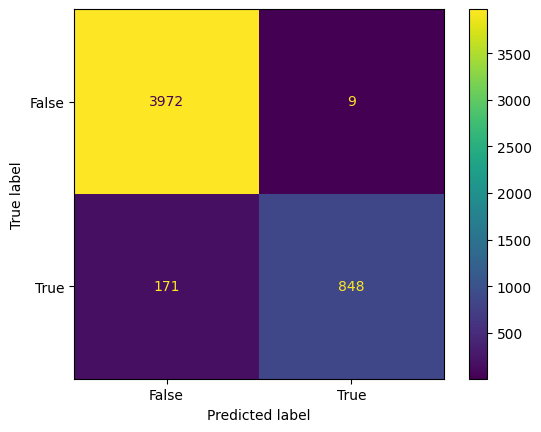

In [55]:
# plot confusion matrix for training data
cm = confusion_matrix(y_train, model.predict(X_train_hotenc), labels=clf.classes_)

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cm_disp.plot(values_format='d')
plt.show()

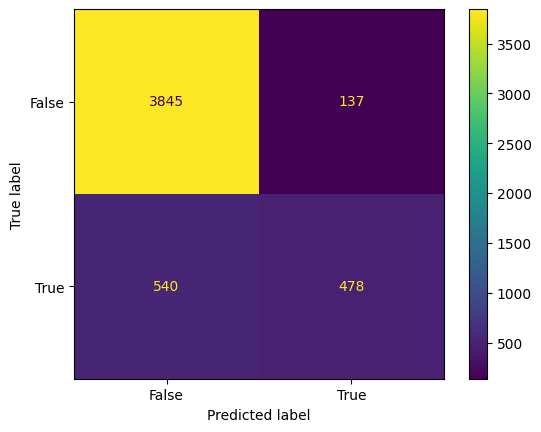

In [56]:
# plot confusion matrix for training data
cm = confusion_matrix(y_test, model.predict(X_test_hotenc), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()